In [1]:
import numpy as np
import scipy as sp
import pickle as pkl
import networkx as nx
from py2neo import Graph
import py2neo
import pandas as pd
import nxviz as nv
import matplotlib.pyplot as plt
from stellargraph import StellarGraph
from BiRank import BiRank
from sklearn.metrics import precision_recall_curve
import shap

from tqdm.notebook import tqdm


%matplotlib inline

C:\Users\bruno\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.0, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
claims_data = pkl.load(open( "claims_data", "rb" ))
counterparty_data = pkl.load(open("counterparties", "rb"))
labels = pkl.load(open("frauds", "rb")).sort_values("SI01_NO_SIN"); labels.describe()

,Proven_fraud,Investigated_case
count,656304.000000,656304.000000
mean,0.003061,0.033631
std,0.055242,0.180277
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [6]:
claims_nodes = claims_data[["SI01_NO_SIN"]].drop_duplicates().set_index("SI01_NO_SIN").sort_values("SI01_NO_SIN")
contract_nodes = claims_data[["SI01_NO_CNT"]].drop_duplicates().set_index("SI01_NO_CNT")
broker_nodes = claims_data[["SI01_C_INTER"]].drop_duplicates().set_index("SI01_C_INTER")

In [7]:
counterparty_nodes = counterparty_data[["C-TIE"]].drop_duplicates()
counterparty_nodes = counterparty_nodes[[cp not in broker_nodes.index for cp in counterparty_nodes["C-TIE"]]]
counterparty_nodes = counterparty_nodes.set_index("C-TIE")

In [8]:
claim_contract = claims_data[["SI01_NO_SIN", "SI01_NO_CNT"]].reset_index(drop=True)
claim_broker = claims_data[["SI01_NO_SIN", "SI01_C_INTER"]].reset_index(drop=True)
claim_counter = counterparty_data[["NO-SIN", "C-TIE"]].reset_index(drop=True)

In [9]:
claim_contract.columns = ["source", "target"]
claim_broker.columns = ["source", "target"]
claim_counter.columns = ["source", "target"]

In [10]:
edges = pd.concat([claim_contract, claim_broker,claim_counter]).reset_index(drop = True)

In [11]:
HG = StellarGraph({"claim" : claims_nodes, "contract" : contract_nodes, "broker" : broker_nodes, "counterparty" : counterparty_nodes}, edges)

In [13]:
degrees = HG.node_degrees()
claim_degrees = pd.Series([degrees[x] for x in list(claims_nodes.index)])
contract_degrees = pd.Series([degrees[x] for x in list(contract_nodes.index)])
broker_degrees = pd.Series([degrees[x] for x in list(broker_nodes.index)])
counterparty_degrees = pd.Series([degrees[x] for x in list(counterparty_nodes.index)])
perc = [.25,.50,.75,.85,.95, .99] 

In [12]:
j = 0
nodes = []
for i in HG.connected_components():
    nodes.append(len(i))
    j +=1
print(j)

825


In [13]:
nodes_summa = {}
for length in nodes:
    if length in nodes_summa.keys():
        nodes_summa[length]+=1
    else:
        nodes_summa[length]=1

In [15]:
nodes = list(HG.nodes("claim"))+list(HG.nodes("contract"))+list(HG.nodes("broker"))+list(HG.nodes("counterparty"))

adjmat_bipartite = HG.to_adjacency_matrix(nodes)[:len(HG.nodes("claim")), len(HG.nodes("claim")):]

In [16]:
fraud = {"FraudInd": labels["Proven_fraud"].values}
fraudMat = pd.DataFrame(fraud)

claim_nodes = pd.DataFrame({"ID": HG.nodes("claim")}).set_index("ID").sort_index()

HG_parties = np.concatenate((HG.nodes("contract"), HG.nodes("broker"), HG.nodes("counterparty")))
party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")

ADJ = adjmat_bipartite.transpose().tocsr()

In [18]:
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat)

Convergence reached.


Text(0.5, 1.0, 'AUC: 1.0')

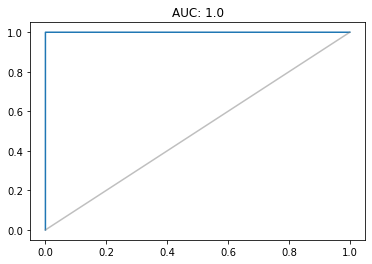

In [20]:
from sklearn import metrics
y = labels["Proven_fraud"].values
pred = Claims_res.sort_values("ID").ScaledScore

fpr, tpr, thresholds = metrics.roc_curve(y,pred)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

Text(0.5, 1.0, 'Average Precision: 0.999')

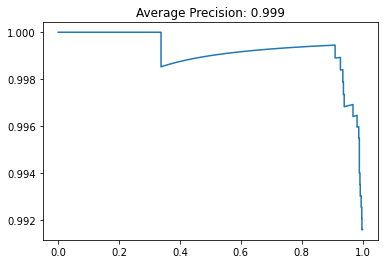

In [21]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

In [22]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size
ADJ_train= ADJ[:train_set_size,:]
fraud_train = {"FraudInd": labels["Proven_fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_train, party_nodes, fraudMat_train)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\NetworkWithFeatures\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


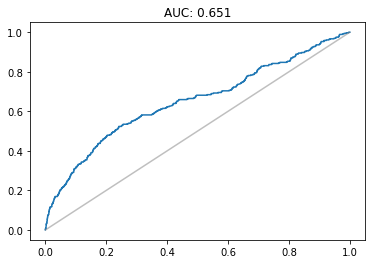

In [23]:
y = labels[train_set_size:]["Proven_fraud"].values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)

plt.plot(fpr,tpr)

plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_Inductive_Connected.pdf")

Text(0.5, 1.0, 'Average Precision: 0.004')

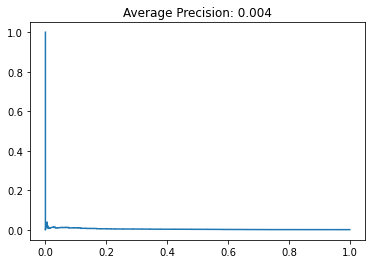

In [24]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

Convergence reached.


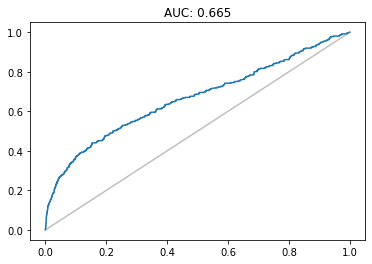

In [25]:
fraud_train = {"FraudInd": labels["Proven_fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

y = labels[train_set_size:]["Proven_fraud"].values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_Transductive_Connected.pdf")

Text(0.5, 1.0, 'Average Precision: 0.007')

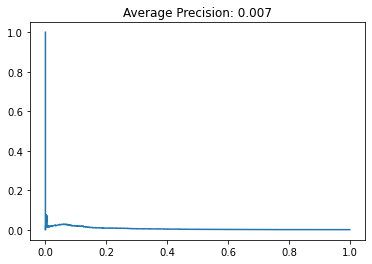

In [26]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

## Introducing the other features

### Claim features

In [27]:
from datetime import timedelta

Here, we will construct the reporting delay (and cap it at 90 days) and we add a column representing the weekday the accident occurred.

We will also redefine H_SIN (timing of the claim) to have a more readable representation. 

In [30]:
reporting_delay =[min(timedelta(days = 90), delay) for delay in claims_data["SI01_D_DCL"]-claims_data["SI01_D_SURV_SIN"]]

In [31]:
claims_data["Reporting_delay"] = reporting_delay
claims_data["Day_Accident"] = claims_data["SI01_D_SURV_SIN"].dt.day_name()
claims_data["Month_Accident"] = claims_data["SI01_D_SURV_SIN"].dt.month_name()

In [32]:
claims_data["SI01_H_SIN"].replace(0, pd.NA, inplace = True)

In [33]:
decimal_hours = claims_data["SI01_H_SIN"]//100+claims_data["SI01_H_SIN"]%100/60
claims_data["Closest_Hour"] = [round(h) if (str(h) != '<NA>') & (str(h) != 'nan') else 0 for h in decimal_hours ]

In [34]:
claims_data.head()

,SI01_NO_SIN,SI01_NO_CNT,SI01_C_INTER,IMM,SI01_CPOST,SI01_C_CAU,SI01_D_DCL,SI01_NB_HIST,SI01_NB_EXPE,SI01_H_SIN,SI01_C_FAM_PROD,SI01_D_SURV_SIN,Reporting_delay,Day_Accident,Month_Accident,Closest_Hour
2120901,000020182003590,020303009036928,15105301,0.0,3150.0,12,2018-03-17,0,0,<NA>,I01,2018-03-12,5 days,Monday,March,0
2222158,000020192013964,021002200311628,10341001,0.0,1180.0,19,2019-12-16,0,0,<NA>,I05,2019-02-11,90 days,Monday,February,0
1999647,000020171035446,010102100896928,40007101,219542.0,4040.0,50,2017-08-29,0,0,1500.0,A01,2017-08-22,7 days,Tuesday,August,15
1644289,000020132004578,020602200105863,10109201,0.0,1070.0,19,2013-06-03,0,0,<NA>,I01,2013-05-31,3 days,Friday,May,0
2021703,000020171057502,011002100887089,15322601,111552.0,5000.0,SS,2018-01-19,1,1,<NA>,A01,2017-09-01,90 days,Friday,September,0


### Counter parties

In this part, we do some feature engineering on the counterparties. More precisely, we count each time of counterparty per claim. We hope that this may have some predictive power.

In [35]:
counterparty_data.head()

,NO-SIN,C-TIE,C-NAT-INTVT,IMM,MRQ-ADV,PUISS-KW
0,000020182003590,0009700,CI,0.0,,0000
1,000020182003590,000000000612615,CL,0.0,,0000
2,000020182003590,000000005135071,TI,305832.0,,0000
3,000020192013964,000000008837733,CL,0.0,,0000
4,000020171035446,000000009145429,CL,219542.0,PEUG PARTNER,0044


In [36]:
counterparty_data_df = pd.pivot_table(counterparty_data, index = "NO-SIN", values = "C-TIE", columns = "C-NAT-INTVT", aggfunc='count').fillna(0)
counterparty_data_df.columns= np.sort(counterparty_data["C-NAT-INTVT"].unique())
counterparty_data_df.reset_index(inplace = True)

In [38]:
labels.reset_index(inplace = True)

In [39]:
merged_cntp = counterparty_data_df.merge(labels[["SI01_NO_SIN", "Proven_fraud"]],left_on = "NO-SIN", right_on = "SI01_NO_SIN")

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
X_train = merged_cntp.iloc[:, 1:38]
y_train = merged_cntp.iloc[:, -1]

In [42]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.8,max_depth=3, random_state=1997).fit(X_train, y_train)

In [44]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)

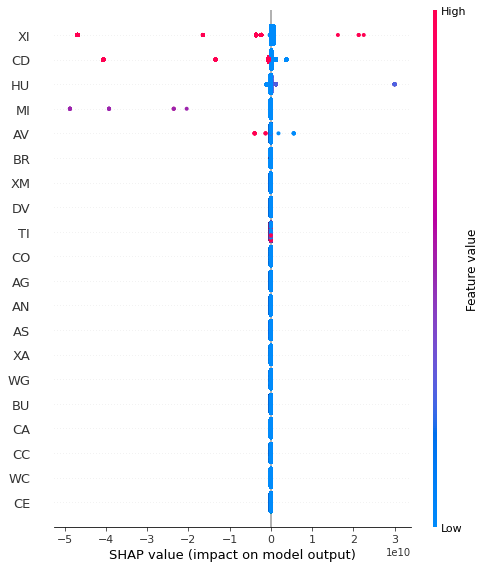

In [47]:
shap.summary_plot(shap_values, X_train)

In [64]:
selected_counterparties = np.sort(counterparty_data["C-NAT-INTVT"].unique())[clf.feature_importances_>0]

In [65]:
selected = ["NO-SIN"]
selected.extend(list(selected_counterparties))
counterparty_data_df = counterparty_data_df[selected]

In [66]:
counterparty_data_df.head() #Boosting only looks at the highly predictive ones, but some can be overshadowed due to correlation
#Try random forest

,NO-SIN,AV,BR,CD,CR,DV,HU,MI,MT,XI,XM
0,000020111059354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000020111059939,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000020112015244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000020121000009,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000020121000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model for full database

In [67]:
full_df = claims_data.merge(
    counterparty_data_df, 
    left_on = "SI01_NO_SIN", 
    right_on = "NO-SIN"
).merge(
    labels[["SI01_NO_SIN", "Proven_fraud"]],
    on = "SI01_NO_SIN"
)

In [70]:
selected_features = ["SI01_C_CAU", 
                     "Reporting_delay",
                     "Day_Accident",
                     "Closest_Hour", 
                     "Month_Accident"]
selected_features.extend(list(counterparty_data_df.columns[1:]))
X_full = full_df.sort_values("SI01_NO_SIN")[selected_features]
y_full = full_df["Proven_fraud"]

In [71]:
X_full.describe().columns

Index(['Reporting_delay', 'Closest_Hour', 'AV', 'BR', 'CD', 'CR', 'DV', 'HU',
       'MI', 'MT', 'XI', 'XM'],
      dtype='object')

In [72]:
from sklearn.preprocessing import OneHotEncoder

In [73]:
all_columns =  set(X_full.columns)
numeric_columns = set(X_full.describe().columns)
factor_columns = all_columns.difference(numeric_columns)

In [74]:
factor_columns

{'Day_Accident', 'Month_Accident', 'SI01_C_CAU'}

In [75]:
X_full['Reporting_delay']=X_full['Reporting_delay'].dt.days

In [78]:
onehot_df = pd.DataFrame(X_full_encoded.toarray())

In [79]:
X_full_onehot = pd.concat([X_full[[*numeric_columns]], onehot_df], axis = 1)

In [80]:
train_size = int(round(0.6*len(y_full),0))

X_train = X_full_onehot.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = X_full_onehot.iloc[train_size:, :]
y_test = y_full[train_size:]

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0419           0.0010            2.03m
         2           0.0412           0.0004            2.07m
         3           0.0413           0.0002            2.02m
         4           0.0412           0.0001            1.86m
         5           0.0407           0.0001            1.84m
         6           0.0410           0.0001            1.80m
         7           0.0405           0.0001            1.77m
         8           0.0403           0.0000            1.73m
         9           0.0404           0.0012            1.69m
        10           0.0391           0.0003            1.64m
        20           0.0388           0.0000            1.48m
        30           0.0387          -0.0000            1.28m
        40           0.0372          -0.0000            1.09m
        50           0.0382           0.0000           56.75s
        60           0.0381           0.0000           45.90s
       

Text(0.5, 1.0, 'AUC: 0.711')

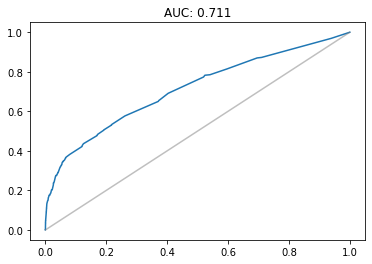

In [81]:
first_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = first_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
#plt.savefig("AUC_intrinsic_features.pdf")

Text(0.5, 1.0, 'Average Precision: 0.007')

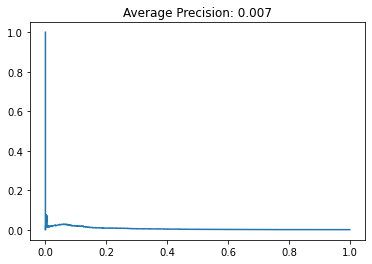

In [82]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

In [83]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size
ADJ_train= ADJ[:train_set_size,:]
fraud_train = {"FraudInd": labels["Proven_fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_train, party_nodes, fraudMat_train)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\NetworkWithFeatures\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.
Convergence reached.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0419           0.0010            1.80m
         2           0.0412           0.0004            2.27m
         3           0.0413           0.0002            2.42m
         4           0.0412           0.0001            2.47m
         5           0.0407           0.0001            2.51m
         6           0.0410           0.0001            2.49m
         7           0.0405           0.0001            2.47m
         8           0.0403           0.0000            2.43m
         9           0.0404           0.0012            2.42m
        10           0.0391           0.0003            2.39m
        20           0.0388           0.0000            1.83m
        30           0.0387          -0.0000            1.47m
        40           0.0372           0.0000            1.32m
        50           0.0384           0.0000            1.13m
        60           0.0384           0.0000           54.02s
       

Text(0.5, 1.0, 'AUC: 0.711')

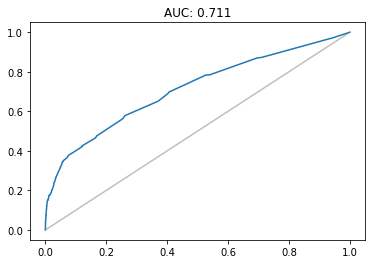

In [84]:
network_feature_df = pd.concat([X_full_onehot, Claims_res[['StdScore']].sort_index()], axis = 1)
train_size = int(round(0.6*len(y_full),0))

X_train = network_feature_df.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = network_feature_df.iloc[train_size:, :]
y_test = y_full[train_size:]

network_feature_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)

y_pred = network_feature_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
#plt.savefig("AUC_intrinsic+network_features.pdf")

Text(0.5, 1.0, 'Average Precision: 0.007')

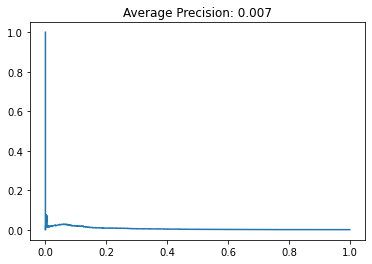

In [85]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))

In [86]:
network_feature_df.columns[network_feature_model.feature_importances_>0]

Index([             'BR',              'XM',              'CD',
                    'DV',              'MT',              'MI',
                    'XI',              'AV',              'CR',
          'Closest_Hour',              'HU', 'Reporting_delay',
                      17,                19,                20,
                      24,                31,                38,
                      57,                74,                84,
                      85,                92,                94,
                      95,        'StdScore'],
      dtype='object')

### Adapting train-test procedure

In [89]:
split_size = int(round(len(y_full)/3,0))


fraud_train = {"FraudInd": labels["Proven_fraud"].values[:split_size]}
fraudMat_train = pd.DataFrame(fraud_train)
validate_set_fraud = {"FraudInd": [0]*(2*split_size)}
fraudMat_test_set = pd.DataFrame(validate_set_fraud)
fraudMat_test = fraudMat_train.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)



Convergence reached.


In [90]:
network_feature_df = pd.concat([X_full_onehot, Claims_res[['StdScore']].sort_index()], axis = 1)

X_train = network_feature_df.iloc[split_size:2*split_size, :]
y_train = y_full[split_size:2*split_size]

X_test = network_feature_df.iloc[2*split_size:, :]
y_test = y_full[2*split_size:]

In [91]:
network_feature_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
intrinsic_feature_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train.iloc[:,:-1], y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0407           0.0011            1.37m
         2           0.0409           0.0002            1.37m
         3           0.0398           0.0003            1.36m
         4           0.0706          -0.1227            1.35m
         5           0.1022           0.0001            1.34m
         6           0.1024           0.0000            1.32m
         7           0.1007          -0.0002            1.31m
         8           0.1011           0.0001            1.29m
         9           0.1003          -0.0000            1.27m
        10           0.0698          -0.0001            1.26m
        20           0.0999           0.0000            1.11m
        30           0.0982          -0.0000           56.96s
        40           0.0996          -0.0000           49.10s
        50           0.1000          -0.0000           41.15s
        60           0.0994          -0.0000           32.86s
       

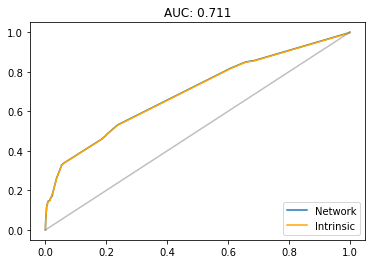

In [92]:
y_pred = intrinsic_feature_model.predict_proba(X_test.iloc[:,:-1])[:,1]
fpr_int, tpr_int, thresholds = metrics.roc_curve(y_test,y_pred)

y_pred = network_feature_model.predict_proba(X_test)[:,1]
fpr_net, tpr_net, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr_net,tpr_net, label = "Network")
plt.plot(fpr_int,tpr_int, color = "orange", label = "Intrinsic")
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.legend(loc = 'lower right')
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("Comparison AUC.pdf")

### Feed the model data into the network

In [93]:
train_size = int(round(0.6*len(y_full),0))

X_train = X_full_onehot.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = X_full_onehot.iloc[train_size:, :]
y_test = y_full[train_size:]

intrinsic_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = intrinsic_model.predict_proba(X_full_onehot)[:,1]

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0419           0.0010            1.92m
         2           0.0412           0.0004            2.06m
         3           0.0413           0.0002            2.06m
         4           0.0412           0.0001            2.08m
         5           0.0407           0.0001            2.08m
         6           0.0410           0.0001            2.07m
         7           0.0405           0.0001            2.08m
         8           0.0403           0.0000            2.06m
         9           0.0404           0.0012            2.05m
        10           0.0391           0.0003            2.00m
        20           0.0388           0.0000            1.76m
        30           0.0387          -0.0000            1.56m
        40           0.0372          -0.0000            1.28m
        50           0.0382           0.0000           58.73s
        60           0.0381           0.0000           44.15s
       

In [94]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size
ADJ_train= ADJ[:train_set_size,:]
fraud_train = {"FraudInd": labels["Proven_fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_train, party_nodes, fraudMat_train)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": y_pred}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

C:\Users\bruno\OneDrive\Documenten\KUL\MaAct2\Thesis\Python\NetworkWithFeatures\BiRank.py:6: RuntimeWarning: divide by zero encountered in true_divide
  Dp = sparse.diags(np.asarray(1 / np.sqrt(adjMat.sum(axis=1).flatten())), [0])


Convergence reached.


ValueError: operands could not be broadcast together with shapes (656304,1) (1050086,1) 

In [ ]:
ADJ = adjmat_bipartite.tocsr()
number_claims = ADJ.shape[0]
train_set_size = int(np.round(0.6*number_claims))
test_set_size = number_claims-train_set_size
ADJ_train= ADJ[:train_set_size,:]



In [ ]:
train_scores = [fraud if label ==1 else prediction for fraud, label, prediction in zip(labels["Proven_fraud"].values[:train_set_size], labels["Investigated_case"].values[:train_set_size], y_pred[:train_set_size])]
test_scores = y_pred[train_set_size:]
fraud_train = {"FraudInd": labels["Proven_fraud"].values[:train_set_size]}
fraudMat_train = pd.DataFrame(fraud_train)
claims_train = claim_nodes[:train_set_size]

ADJ = ADJ_train.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_train, party_nodes, fraudMat_train)

fraud_train_res = {"FraudInd": Claims_res.sort_values("ID")["ScaledScore"].values}
test_set_fraud = {"FraudInd": test_scores}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claim_nodes, party_nodes, fraudMat_test)

In [ ]:
y = labels[train_set_size:]["Proven_fraud"].values
pred = Claims_res.sort_values("ID")[train_set_size:].ScaledScore
fpr, tpr, thresholds = metrics.roc_curve(y,pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_ModelInNetwork.pdf")

In [ ]:
precision, recall, thresholds = precision_recall_curve(y, pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y, pred),3)))